In [1]:
%cd /workspace
from nuscenes.nuscenes import NuScenes, NuScenesExplorer
import fiftyone as fo
import matplotlib.pyplot as plt
import numpy as np
import helpers
import open3d as o3d

#reload all dependencies
%load_ext autoreload
%autoreload 2

/workspace


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# prepare the dataset
DATASET_ROOT = "/datastore/nuScenes/"
dataset = fo.load_dataset("nuscenes")
nusc = NuScenes(version='v1.0-trainval', dataroot=DATASET_ROOT, verbose=False)
explorer = NuScenesExplorer(nusc)

In [3]:
lidar_sample = dataset.select_group_slices(["LIDAR_TOP"]).first()
camera_sample = dataset.select_group_slices(["CAM_FRONT"]).first()

lidar_token = lidar_sample.sample_token
camera_token = camera_sample.sample_token

In [6]:
points, coloring, image = explorer.map_pointcloud_to_image(lidar_token, camera_token)

In [13]:
points_projected, coloring, image, visible_indices = helpers.map_pointcloud_to_image_with_indices(nusc, lidar_token, camera_token)

## Visaulize points projected into the image

<class 'PIL.JpegImagePlugin.JpegImageFile'>


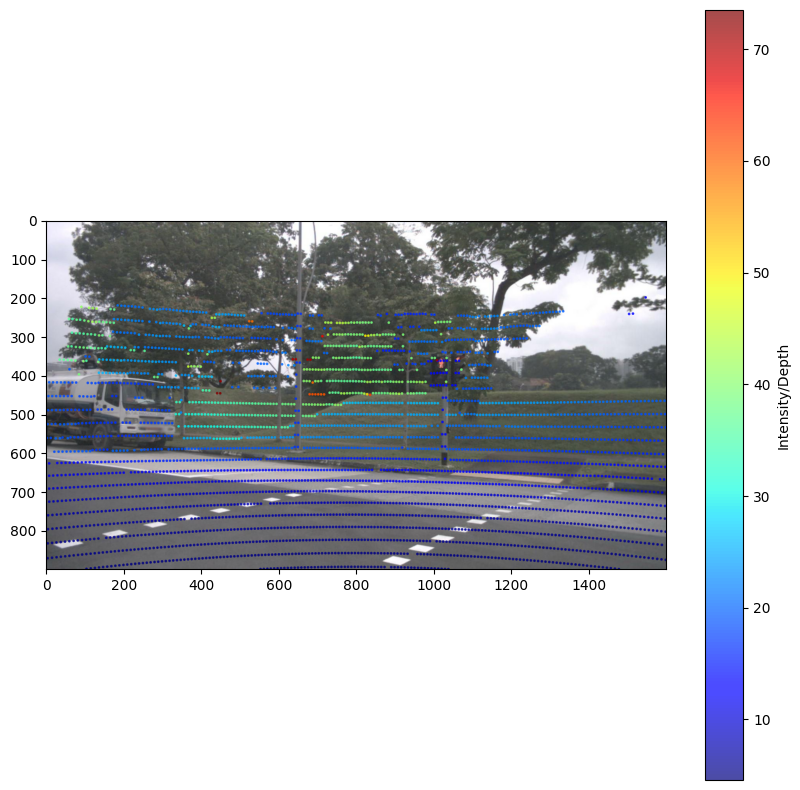

In [46]:
helpers.visualize_pointcloud_on_image(image, points_projected, coloring)

## Visualize the masks projected into the image

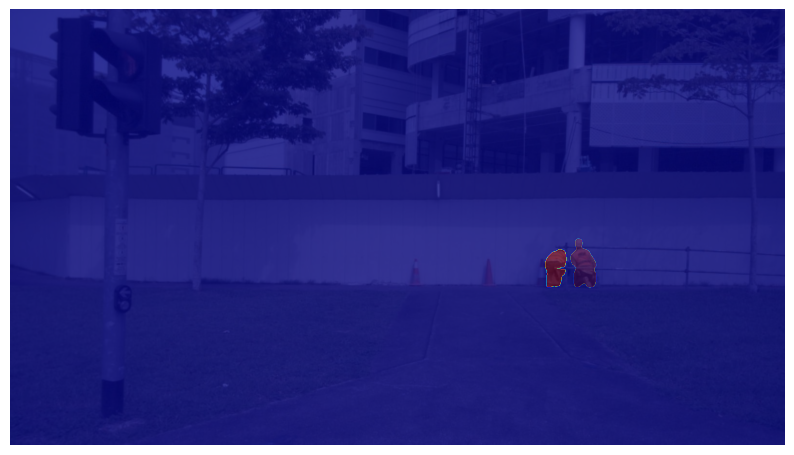

In [19]:
helpers.visualize_full_mask_on_image(image, camera_sample.pseudo_masks)

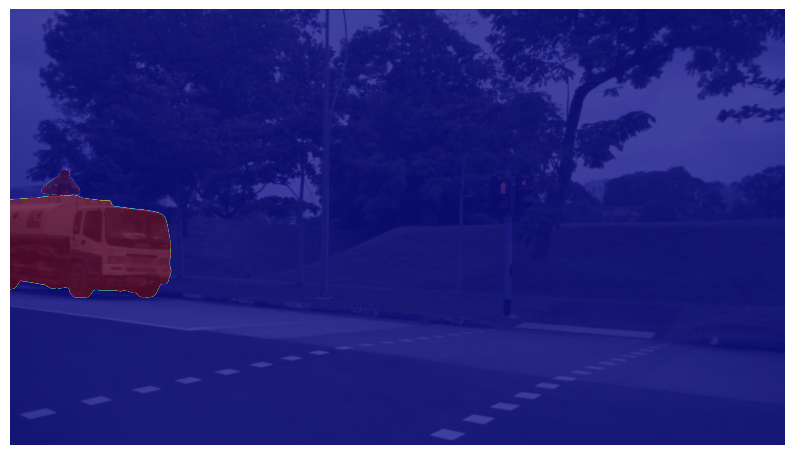

In [47]:
helpers.visualize_full_mask_on_image(image, camera_sample.pseudo_masks)

## Filter lidar points by the mask

In [14]:
pcd = o3d.io.read_point_cloud(lidar_sample.filepath)
lidar_data = np.asarray(pcd.points).T
point_classes = -1 * np.ones(lidar_data.shape[1], dtype=int)
visible_labels = helpers.assign_labels_from_masks(points_projected, camera_sample)

In [152]:
point_classes[visible_indices] = visible_labels

In [12]:
for group in dataset.iter_groups():
    cam_sample = group["CAM_FRONT"]
    break

In [14]:
cam_sample.metadata.width, cam_sample.metadata.height

(1600, 900)

In [8]:
nusc.get('lidarseg', lidar_token)

{'token': '3388933b59444c5db71fade0bbfef470',
 'sample_data_token': '3388933b59444c5db71fade0bbfef470',
 'filename': 'lidarseg/v1.0-trainval/3388933b59444c5db71fade0bbfef470_lidarseg.bin'}

In [9]:
nusc.list_lidarseg_categories(sort_by='count')

Calculating semantic point stats for nuScenes-lidarseg...
 19  vehicle.emergency.ambulance              nbr_points=       2,218
  1  animal                                   nbr_points=       5,385
  5  human.pedestrian.personal_mobility       nbr_points=       8,723
  7  human.pedestrian.stroller                nbr_points=       8,809
  6  human.pedestrian.police_officer          nbr_points=       9,159
  3  human.pedestrian.child                   nbr_points=       9,655
  8  human.pedestrian.wheelchair              nbr_points=      12,168
 20  vehicle.emergency.police                 nbr_points=      59,590
 10  movable_object.debris                    nbr_points=      66,861
  4  human.pedestrian.construction_worker     nbr_points=     139,443
 14  vehicle.bicycle                          nbr_points=     141,351
 13  static_object.bicycle_rack               nbr_points=     163,126
 15  vehicle.bus.bendy                        nbr_points=     357,463
 21  vehicle.motorcycle         

In [10]:
lidar_data = nusc.get('sample_data', lidar_token)

In [4]:
lidar_datafirst_scene = nusc.scene[0]

In [5]:
first_scene = nusc.scene[0]
first_sample_token = first_scene['first_sample_token']

In [6]:
first_sample = nusc.get('sample', first_sample_token)


In [7]:
lidar_token = first_sample['data']['LIDAR_TOP']
lidar_data = nusc.get('sample_data', lidar_token)


In [11]:
import os
lidar_filepath = os.path.join(nusc.dataroot, lidar_data['filename'])
lidar_filepath

'/datastore/nuScenes/samples/LIDAR_TOP/n015-2018-07-18-11-07-57+0800__LIDAR_TOP__1531883530449377.pcd.bin'

In [8]:
nusc.get('lidarseg', lidar_token)

{'token': '3388933b59444c5db71fade0bbfef470',
 'sample_data_token': '3388933b59444c5db71fade0bbfef470',
 'filename': 'lidarseg/v1.0-trainval/3388933b59444c5db71fade0bbfef470_lidarseg.bin'}

In [12]:
lidarseg_filepath = os.path.join(nusc.dataroot, nusc.get('lidarseg', lidar_token)['filename'])
lidarseg_filepath

'/datastore/nuScenes/lidarseg/v1.0-trainval/3388933b59444c5db71fade0bbfef470_lidarseg.bin'

In [13]:
lidarseg_labels = np.fromfile(lidarseg_filepath, dtype=np.uint8)
print(lidarseg_labels)

[24 24 24 ... 28 28 28]


: 

In [ ]:
lidarseg_labels

In [9]:
vehicle_labels = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
human_labels = [2, 3, 4, 5, 6, 7, 8]
ego_vehicle_label = [31]

[17, 23, 16, 15, 14, 21, 18, 22, 19, 20, 31, 2, 3, 4, 5, 6, 7, 8]

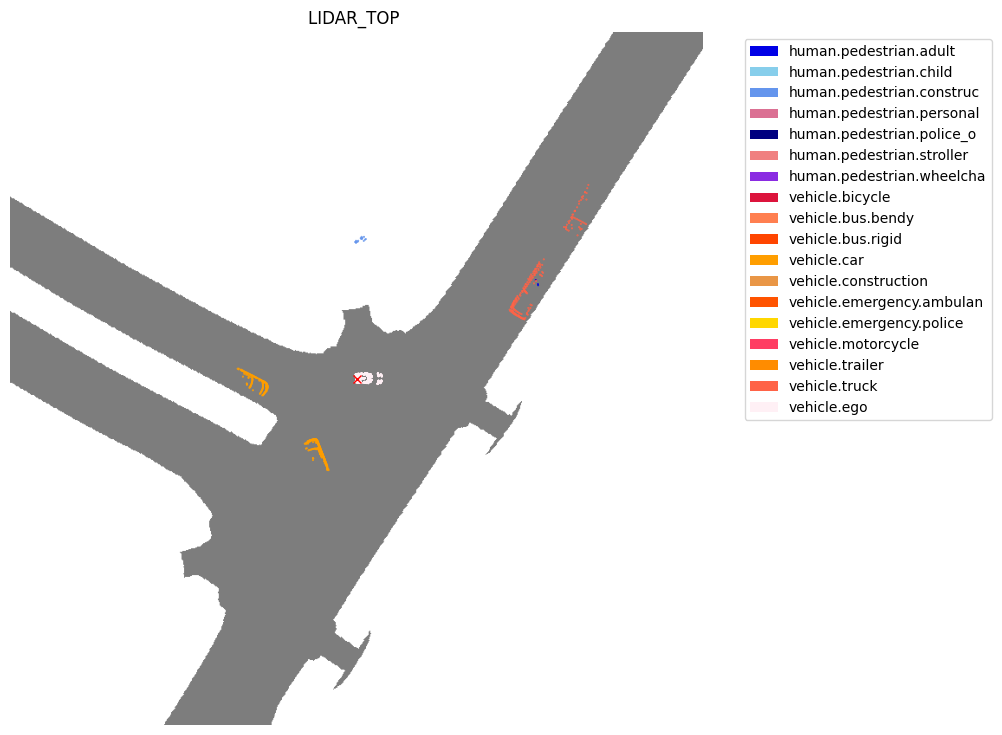

In [33]:
vehicle_labels = [17, 23, 16, 15, 14, 21, 18, 22, 19, 20, 31]
human_labels = [2, 3, 4, 5, 6, 7, 8]

nusc.render_sample_data(lidar_token,
                        with_anns=False,
                        show_lidarseg=True,
                        show_lidarseg_legend=True,
                        filter_lidarseg_labels=vehicle_labels+human_labels+ego_vehicle_label)

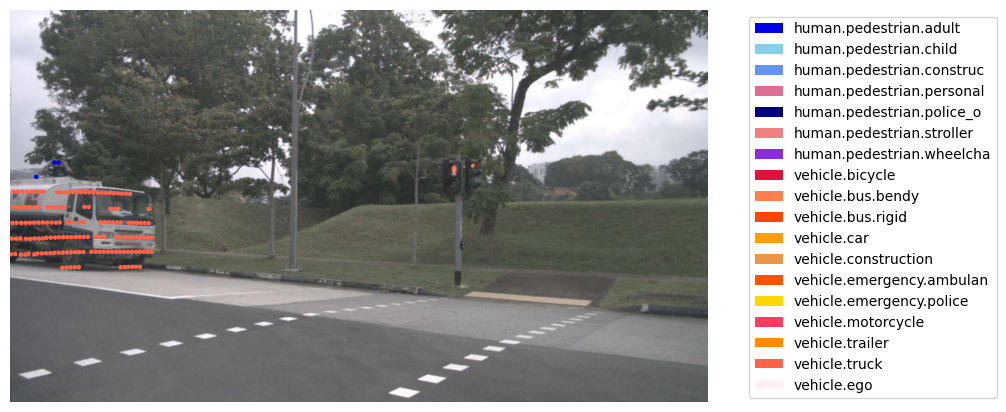

In [43]:
nusc.render_pointcloud_in_image(first_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_FRONT',
                                render_intensity=False,
                                show_lidarseg=True,
                                filter_lidarseg_labels=vehicle_labels+human_labels,
                                show_lidarseg_legend=True)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


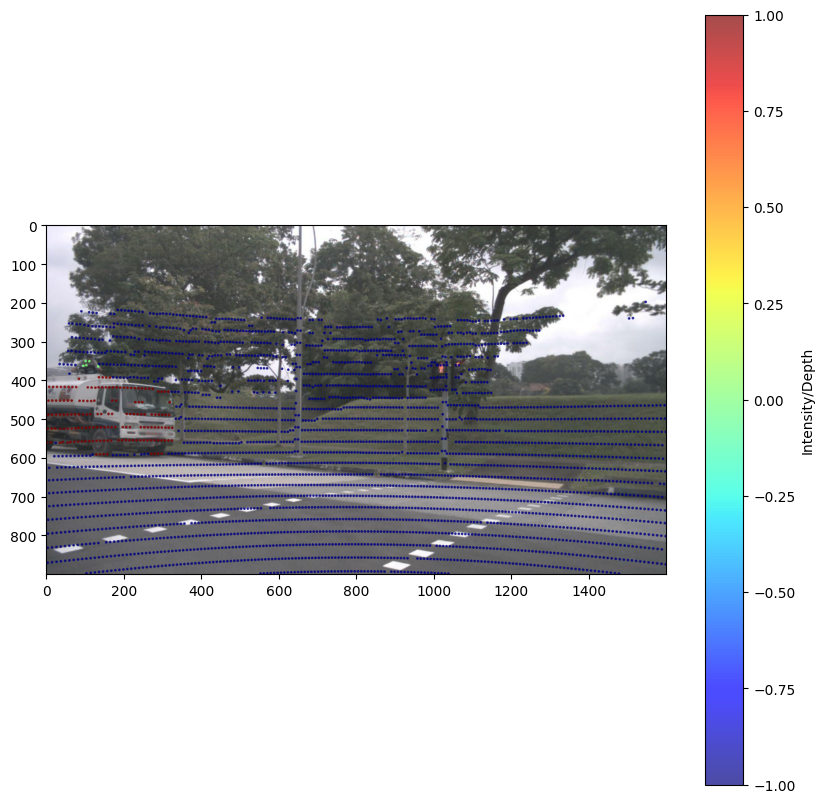

In [51]:
helpers.visualize_pointcloud_on_image(image, points_projected, coloring=visible_labels)

In [8]:
nusc.lidarseg_name2idx_mapping

{'noise': 0,
 'animal': 1,
 'human.pedestrian.adult': 2,
 'human.pedestrian.child': 3,
 'human.pedestrian.construction_worker': 4,
 'human.pedestrian.personal_mobility': 5,
 'human.pedestrian.police_officer': 6,
 'human.pedestrian.stroller': 7,
 'human.pedestrian.wheelchair': 8,
 'movable_object.barrier': 9,
 'movable_object.debris': 10,
 'movable_object.pushable_pullable': 11,
 'movable_object.trafficcone': 12,
 'static_object.bicycle_rack': 13,
 'vehicle.bicycle': 14,
 'vehicle.bus.bendy': 15,
 'vehicle.bus.rigid': 16,
 'vehicle.car': 17,
 'vehicle.construction': 18,
 'vehicle.emergency.ambulance': 19,
 'vehicle.emergency.police': 20,
 'vehicle.motorcycle': 21,
 'vehicle.trailer': 22,
 'vehicle.truck': 23,
 'flat.driveable_surface': 24,
 'flat.other': 25,
 'flat.sidewalk': 26,
 'flat.terrain': 27,
 'static.manmade': 28,
 'static.other': 29,
 'static.vegetation': 30,
 'vehicle.ego': 31}